# Transfer learning for Object detection models

In the first part of our notebook, we created annotated images of people from LFW dataset. In this notebook, we will train an existing model to recognize those 62 people using Tensorflow object detection library.  
P.S. refer to version 17 for the quantized model; this is a float type model.

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print(os.listdir("/kaggle/input//"))
# Any results you write to the current directory are saved as output.

['ssd-mobilenet-v1-quantized-300x300-coco14', 'my-training', 'float-trained16k', 'faces-data', 'ssdmobilenetv2-quant', 'face-recognition-part-1']


In [2]:
import tensorflow as tf
tf.__version__
#cv2.__version__

'1.12.0'

In [3]:
%cd /kaggle/working/ 
# changing the directory for installation of below modules
# tensorflow models section has an object detection library
# piping logs to text files, otherwise the notebook is not very readable
!git clone --quiet https://github.com/tensorflow/models.git > models.txt
# protobuf is needed for creating py files from models library above
!apt-get install -qq protobuf-compiler > proto.txt 
# pycoco for coco scores
!pip install -q pycocotools > pycoco.txt
# creating py files from protos
%cd /kaggle/working/models/research
!protoc object_detection/protos/*.proto --python_out=.
# setting path, if not set, python can not use object detection library (from models)
import os
os.environ['PYTHONPATH'] += ':/kaggle/working/models/research/:/kaggle/working/models/research/slim/'
# if prints OK, then installation and environment are set up correctly 
!python object_detection/builders/model_builder_test.py

/kaggle/working
debconf: delaying package configuration, since apt-utils is not installed
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/kaggle/working/models/research
......................
----------------------------------------------------------------------
Ran 22 tests in 0.122s

OK


In [4]:
# copy coco config to the working dir for editing
!cp /kaggle/input/my-training/nssd_mobilenet_v2_coco.config /kaggle/working/

In [5]:
# modified from https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/
# changing config file by changing the path to records and setting variables
import re
pipeline_fname="/kaggle/working/nssd_mobilenet_v2_coco.config"
fine_tune_checkpoint="/kaggle/input/my-training/model.ckpt"
train_record_fname="/kaggle/input/face-recognition-part-1/train.tfrecord"
test_record_fname="/kaggle/input/face-recognition-part-1/test.tfrecord"
label_map_pbtxt_fname="/kaggle/input/face-recognition-part-1/object_label.pbtxt"
batch_size=64
num_steps=20000 # more steps of training gives higher accuracy
num_classes=62 # specify classes
num_examples=5000 # generate examples by augmenting existing images in tfrecords

with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files both train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(test.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)
    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)
    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)
    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    s = re.sub('num_examples: [0-9]+',
               'num_examples: {}'.format(num_examples), s) 
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [6]:
# folder for saving trained model
#!rm -r /kaggle/working/training
os.mkdir('/kaggle/working/training')

In [7]:
#!ls /kaggle/working/
train='/kaggle/working/training/'

In [8]:
# if you are training for the first time, you can remove this cell!!!
# this is for further training from my last checkpoint
!cp /kaggle/input/float-trained16k/* /kaggle/working/training/
#opening checkpoint text file to edit the last step:
ch=open('/kaggle/working/training/checkpoint','w')
ch.write('model_checkpoint_path: "model.ckpt-16000"\nall_model_checkpoint_paths: "model.ckpt-16000"')
ch.close() # without checkpoint step, training does not continue

In [9]:
#training starts by running model_main.py and passing the paths
!python /kaggle/working/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir=/kaggle/working/training/ \
    --alsologtostderr > /kaggle/working/train.txt
print("Finished training")

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
2019-02-24 07:50:29.082001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-24 07:50:29.082531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2019-02-24 07:50:29.082577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-02-24 07:50:30.370886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interco

In [10]:
!ls /kaggle/working/training
#!cat {pipeline_fname}

checkpoint
eval_0
events.out.tfevents.1550994622.a042e34ce962
export
graph.pbtxt
model.ckpt-19352.data-00000-of-00001
model.ckpt-19352.index
model.ckpt-19352.meta
model.ckpt-19532.data-00000-of-00001
model.ckpt-19532.index
model.ckpt-19532.meta
model.ckpt-19692.data-00000-of-00001
model.ckpt-19692.index
model.ckpt-19692.meta
model.ckpt-19852.data-00000-of-00001
model.ckpt-19852.index
model.ckpt-19852.meta
model.ckpt-20000.data-00000-of-00001
model.ckpt-20000.index
model.ckpt-20000.meta


In [11]:
!cp {pipeline_fname} /kaggle/working/training/
conf_path='/kaggle/working/training/nssd_mobilenet_v2_coco.config'

In [12]:
#save frozen graph of the model for inference later (for notebook usage only, not for tflite converting)
import re
import numpy as np

output_directory = '/kaggle/working/trained_model'

lst = os.listdir(train)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(train, last_model)

print(last_model_path)
!python /kaggle/working/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path} \
    > /kaggle/working/graph.txt
print('Finished exporting')

/kaggle/working/training/model.ckpt-20000
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
336 ops no flops stats due to incomplete shapes.
Incomplete shape.
Incomplete shape.
336 ops no flops stats due to incomplete shapes.
Incomplete shape.
Incomplete shape.
2019-02-24 12:03:05.210090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-24 12:03:05.210639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2019-02-24 12:03:05.210683: I tensorflow/core/common_runtime/gpu/g

In [13]:
!ls /kaggle/working/trained_model/

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [14]:
os.mkdir('/kaggle/working/freezetflite')
outd='/kaggle/working/freezetflite'

In [15]:
# freezing graph for tensorflow lite for android use
!python /kaggle/working/models/research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path={conf_path} \
--trained_checkpoint_prefix={last_model_path} \
--output_directory={outd} \
--add_postprocessing_op=true

2019-02-24 12:03:27.755365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-24 12:03:27.755890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2019-02-24 12:03:27.755932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-02-24 12:03:28.085165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-02-24 12:03:28.085235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-02-24 12:03:28.085263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-02-24 12:03:28.085616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 

In [16]:
# converting frozen graph to obtain tflite, used on Android later
!tflite_convert  --graph_def_file=/kaggle/working/freezetflite/tflite_graph.pb \
--output_file=/kaggle/working/freezetflite/62faces_float.tflite \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--input_shape=1,300,300,3 \
--allow_custom_ops 

2019-02-24 12:03:41.650077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-24 12:03:41.650567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2019-02-24 12:03:41.650609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-02-24 12:03:41.992139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-02-24 12:03:41.992204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-02-24 12:03:41.992235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-02-24 12:03:41.992563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 

Our model has been trained. Now we will run inference on some images to check whether it is detecting and recognizing faces.

/kaggle/working/models/research/object_detection


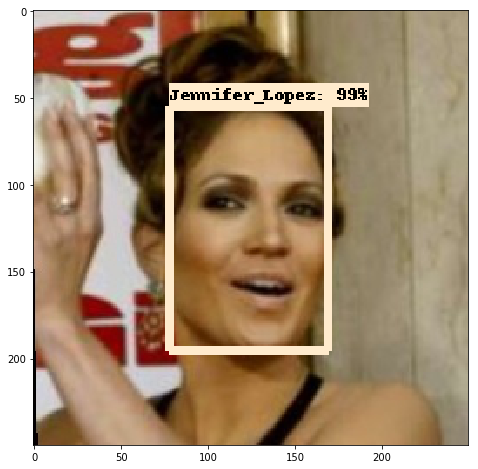

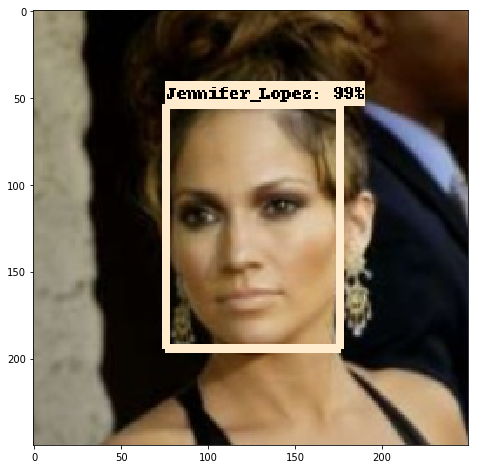

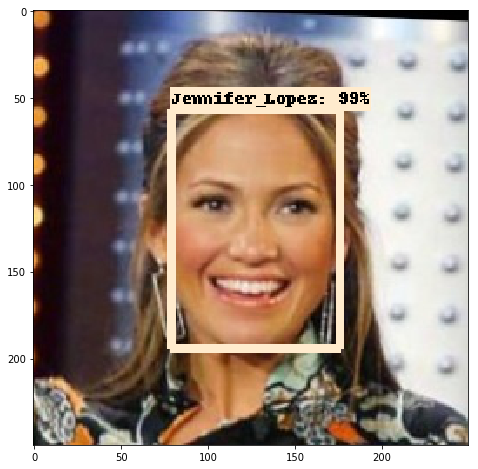

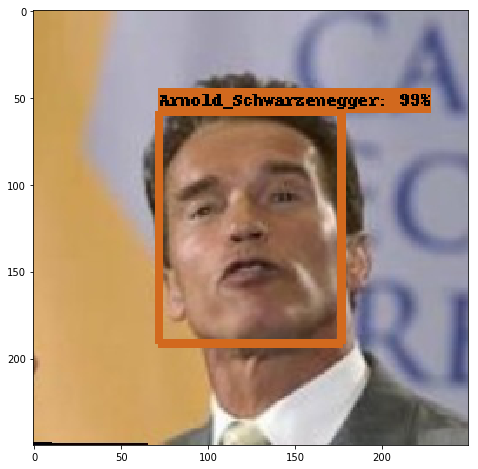

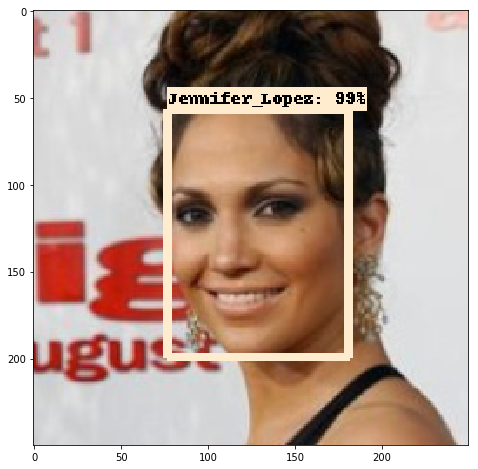

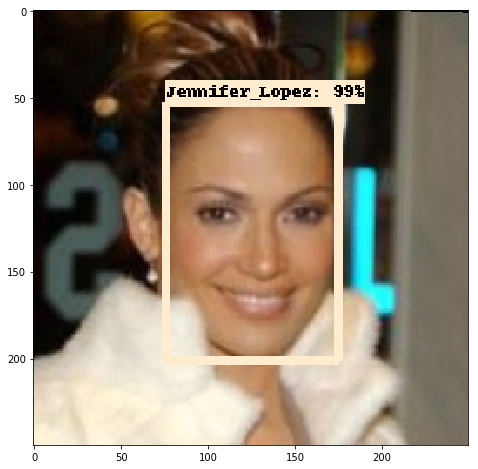

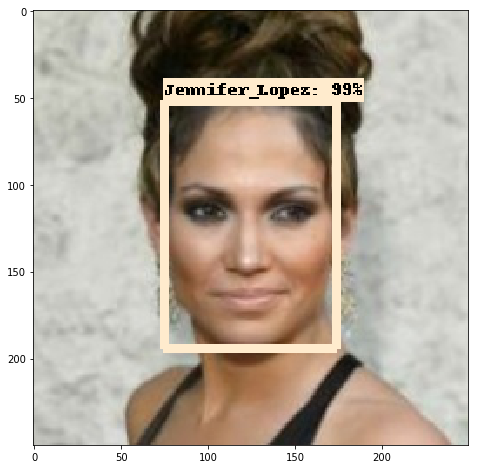

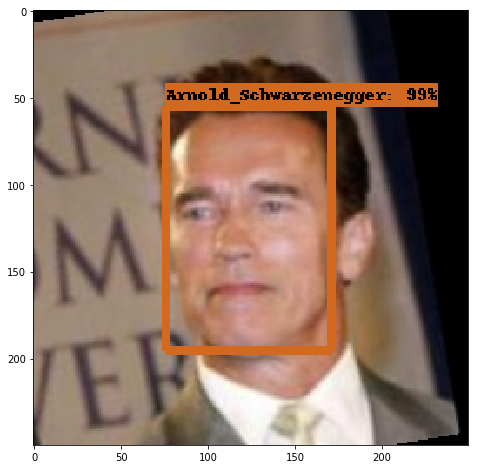

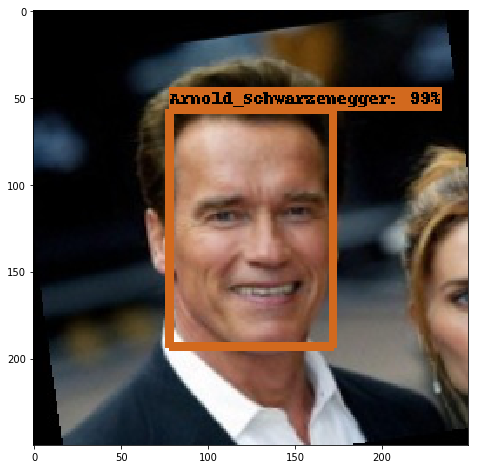

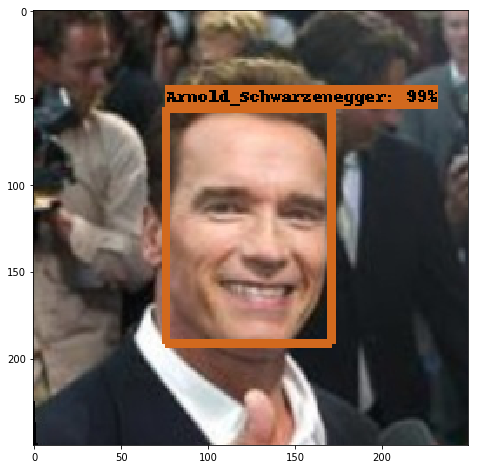

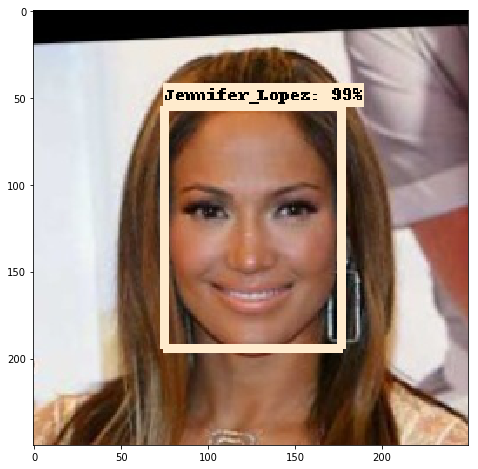

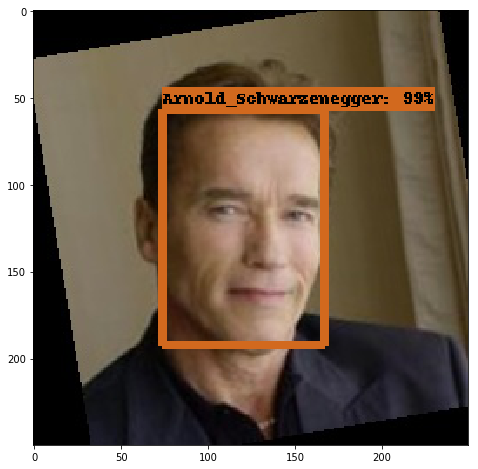

In [17]:
# modified from https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/
%cd /kaggle/working/models/research/object_detection
import warnings
warnings.filterwarnings('ignore')

PATH_TO_CKPT='/kaggle/working/trained_model/frozen_inference_graph.pb'
PATH_TO_LABELS = label_map_pbtxt_fname
PATH_DIR ='/kaggle/input/faces-data/'
TEST_IMAGE_PATHS =[os.path.join(PATH_DIR+i) for i in os.listdir(PATH_DIR)]

#import matplotlib; matplotlib.use('Agg')
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
#from matplotlib import pyplot as plt

from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
#%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=5)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [18]:
import shutil
shutil.rmtree('/kaggle/working/models')

In [19]:
!ls /kaggle/working/training/

sh: 0: getcwd() failed: No such file or directory
checkpoint
eval_0
events.out.tfevents.1550994622.a042e34ce962
export
graph.pbtxt
model.ckpt-19352.data-00000-of-00001
model.ckpt-19352.index
model.ckpt-19352.meta
model.ckpt-19532.data-00000-of-00001
model.ckpt-19532.index
model.ckpt-19532.meta
model.ckpt-19692.data-00000-of-00001
model.ckpt-19692.index
model.ckpt-19692.meta
model.ckpt-19852.data-00000-of-00001
model.ckpt-19852.index
model.ckpt-19852.meta
model.ckpt-20000.data-00000-of-00001
model.ckpt-20000.index
model.ckpt-20000.meta
nssd_mobilenet_v2_coco.config


In [20]:
!ls /kaggle/working/

sh: 0: getcwd() failed: No such file or directory
__notebook__.ipynb  graph.txt			   proto.txt   trained_model
__output__.json     models.txt			   pycoco.txt  training
freezetflite	    nssd_mobilenet_v2_coco.config  train.txt


In [21]:
!ls /kaggle/working/trained_model/

sh: 0: getcwd() failed: No such file or directory
checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config
